**Install dependencies**

In [1]:
# %%capture
# !pip install openvino
# !pip install -U matplotlib
# !pip install -U pillow
# !pip install -U numpy
# !pip install -U pandas

In [2]:
from openvino.runtime import Core
import matplotlib
import PIL
import numpy as np
import json

In [3]:
import pandas as pd
pd.set_option('max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

**Select a test image**

In [4]:
test_file = 'demo.jpg'

(1535, 864)


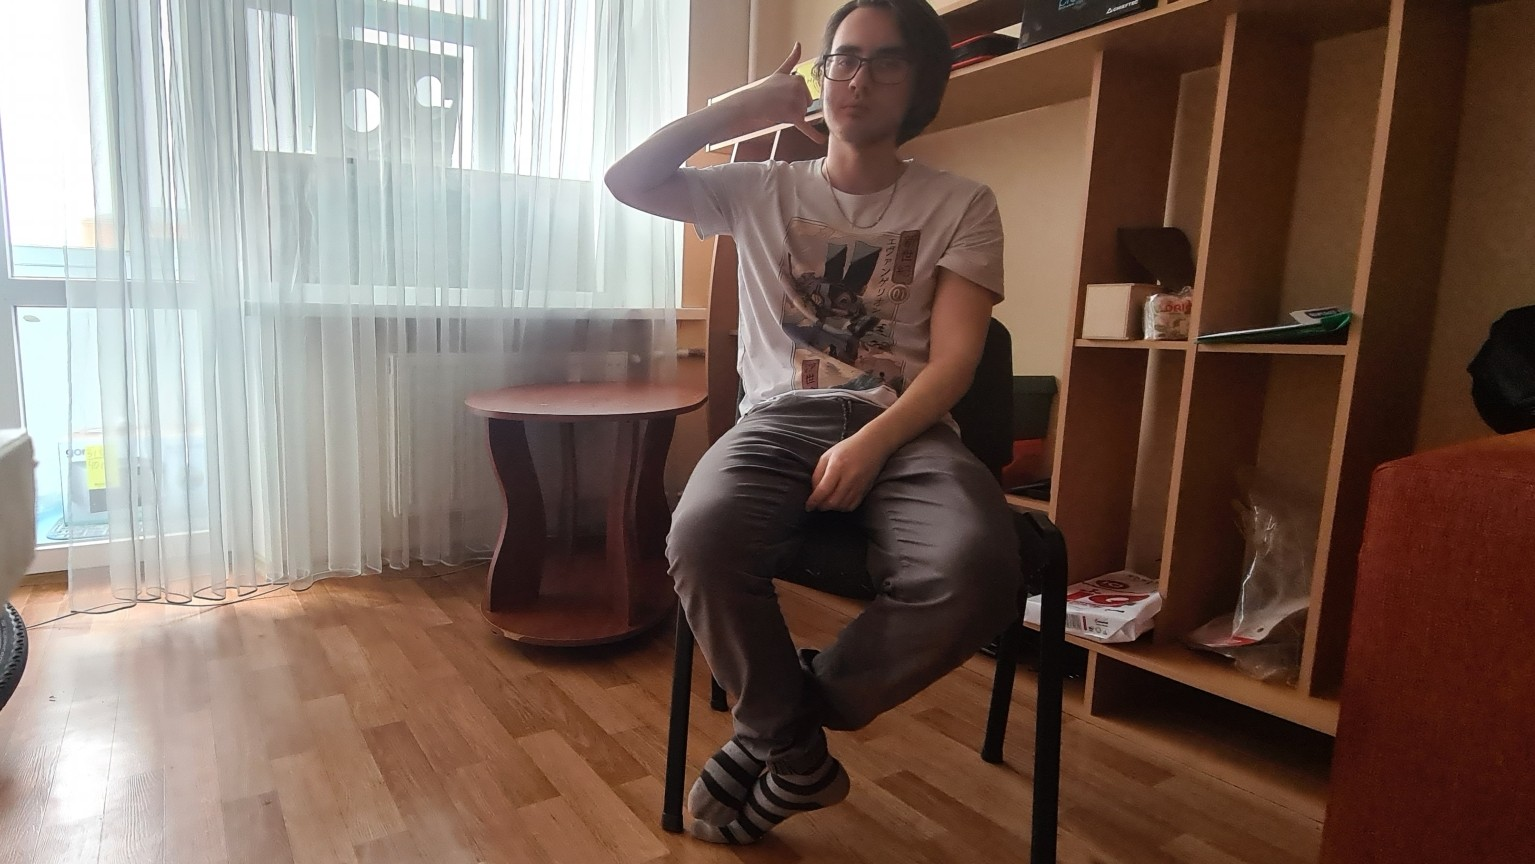

In [5]:
test_img = PIL.Image.open(test_file).convert('RGB')
print(test_img.size)
test_img

**Define stride values**

In [6]:
strides = [8, 16, 32]
max_stride = max(strides)

**Calculate valid input dimensions**

In [7]:
input_w = test_img.width - (test_img.width % max_stride)
input_h = test_img.height - (test_img.height % max_stride)
input_w, input_h

(1504, 864)

**Calculate corner locations for cropped image**

In [8]:
left = (test_img.width - input_w)/2
upper = (test_img.height - input_h)/2
right = test_img.width - left
lower = test_img.height - upper
left, upper, right, lower

(15.5, 0.0, 1519.5, 864.0)

**Crop image to supported resolution**

(1504, 864)


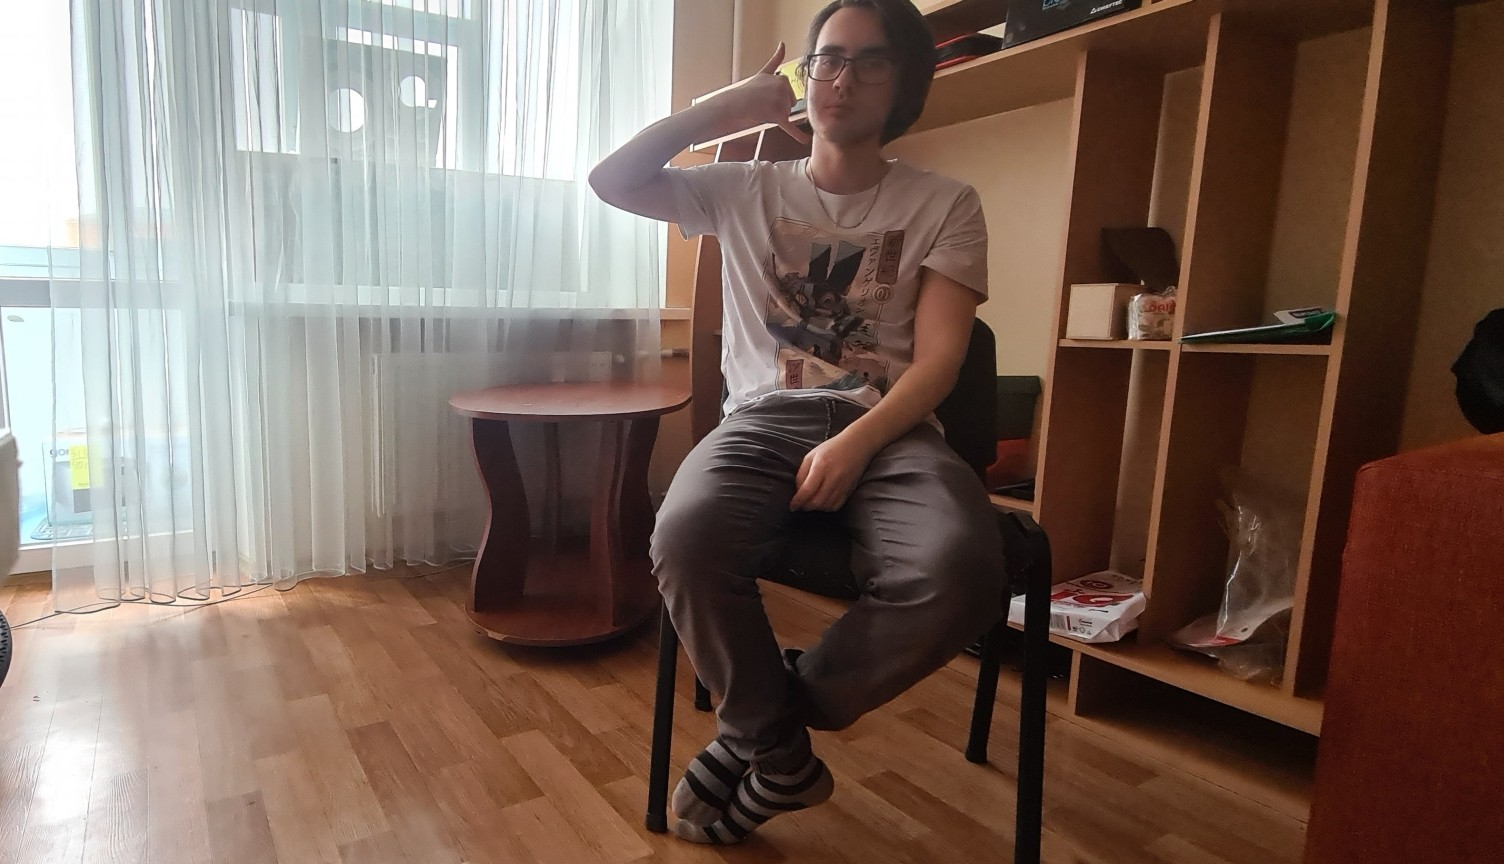

In [9]:
test_img = test_img.crop((left, upper, right, lower))
print(test_img.size)
test_img

**Define model name**

In [10]:
model_name = 'hagrid-sample-250k-384p'

**Define path to OpenVINO IR model**

In [11]:
ir_path = f"{model_name}-YOLOX.xml"
ir_path

'hagrid-sample-250k-384p-YOLOX.xml'

**Convert image to numpy array and scale pixel values**

In [12]:
# Convert image to tensor
img_tensor = np.array(test_img).transpose((2, 0, 1))
# Scale pixels values from [0,255] to [0,1]
scaled_tensor = img_tensor / 255

**Batch input tensor**

In [13]:
input_image = np.expand_dims(scaled_tensor, axis=0)
input_image.shape

(1, 3, 864, 1504)

**Get available OpenVINO compute devices**

In [14]:
ie = Core()
devices = ie.available_devices
for device in devices:
    device_name = ie.get_property(device_name=device, name="FULL_DEVICE_NAME")
    print(f"{device}: {device_name}")

CPU: 11th Gen Intel(R) Core(TM) i7-11700K @ 3.60GHz


**Perform inference using OpenVINO IR model**

In [15]:
# Load the network in Inference Engine
ie = Core()
model_ir = ie.read_model(model=ir_path)
model_ir.reshape(input_image.shape)
compiled_model_ir = ie.compile_model(model=model_ir, device_name="CPU")

# Get input and output layers
input_layer_ir = next(iter(compiled_model_ir.inputs))
output_layer_ir = next(iter(compiled_model_ir.outputs))

# Run inference on the input image
res_ir = compiled_model_ir([input_image])[output_layer_ir]

**Define method to generate stride values to navigate the raw model output**

In [16]:
def generate_grid_strides(height, width, strides=[8, 16, 32]):
    
    grid_strides = []

    # Iterate through each stride value
    for stride in strides:
        # Calculate the grid dimensions
        grid_height = height // stride
        grid_width = width // stride

        # Store each combination of grid coordinates
        for g1 in range(grid_height):
            
            for g0 in range(grid_width):
                grid_strides.append({'grid0':g0, 'grid1':g1, 'stride':stride })
    
    return grid_strides

**Generate stride values to navigate model output**

In [17]:
grid_strides = generate_grid_strides(test_img.height, test_img.width, strides)

**Define method to generate object detection proposals from the raw model output**

In [18]:
def generate_yolox_proposals(feat_ptr, proposal_length, grid_strides, bbox_conf_thresh=0.3):
    
    proposals = []
    
    # Obtain the number of classes the model was trained to detect
    num_classes = proposal_length - 5

    for anchor_idx in range(len(grid_strides)):
        
        # Get the current grid and stride values
        grid0 = grid_strides[anchor_idx]['grid0']
        grid1 = grid_strides[anchor_idx]['grid1']
        stride = grid_strides[anchor_idx]['stride']

        # Get the starting index for the current proposal
        start_idx = anchor_idx * proposal_length

        # Get the coordinates for the center of the predicted bounding box
        x_center = (feat_ptr[start_idx + 0] + grid0) * stride
        y_center = (feat_ptr[start_idx + 1] + grid1) * stride

        # Get the dimensions for the predicted bounding box
        w = np.exp(feat_ptr[start_idx + 2]) * stride
        h = np.exp(feat_ptr[start_idx + 3]) * stride

        # Calculate the coordinates for the upper left corner of the bounding box
        x0 = x_center - w * 0.5
        y0 = y_center - h * 0.5

        # Get the confidence score that an object is present
        box_objectness = feat_ptr[start_idx + 4]

        # Initialize object struct with bounding box information
        obj = { 'x0':x0, 'y0':y0, 'width':w, 'height':h, 'label':0, 'prob':0 }

        # Find the object class with the highest confidence score
        for class_idx in range(num_classes):
            
            # Get the confidence score for the current object class
            box_cls_score = feat_ptr[start_idx + 5 + class_idx]
            # Calculate the final confidence score for the object proposal
            box_prob = box_objectness * box_cls_score
            
            # Check for the highest confidence score
            if (box_prob > obj['prob']):
                obj['label'] = class_idx
                obj['prob'] = box_prob

        # Only add object proposals with high enough confidence scores
        if obj['prob'] > bbox_conf_thresh: proposals.append(obj)
    
    proposals.sort(key=lambda x:x['prob'], reverse=True)
    return proposals

**Define minimum confidence score for keeping bounding box proposals**

In [19]:
bbox_conf_thresh = 0.65

**Define path to the color map for the selected model**

In [20]:
color_map_file_path = f'{model_name}-colormap.json'

**Load the color map for the selected model**

In [21]:
with open(color_map_file_path, "r") as read_file:
    raw_json = read_file.read()
    color_map = json.loads(raw_json)
pd.DataFrame(color_map['items'])

label                        color
0              call              [0.0, 1.0, 0.0]
1        no_gesture              [1.0, 0.0, 1.0]
2           dislike              [0.0, 0.5, 1.0]
3              fist              [1.0, 0.5, 0.0]
4              four             [0.5, 0.75, 0.5]
5              like  [0.22306, 0.03884, 0.63863]
6              mute  [0.83834, 0.02618, 0.28495]
7                ok  [0.14941, 0.49409, 0.07838]
8               one  [0.87966, 0.48671, 0.89008]
9              palm              [0.0, 1.0, 1.0]
10            peace  [0.91938, 0.99861, 0.05139]
11   peace_inverted              [0.0, 1.0, 0.5]
12             rock  [0.53346, 0.91229, 0.96735]
13             stop  [0.51542, 0.33546, 0.43115]
14    stop_inverted  [0.57386, 0.70814, 0.00274]
15            three  [0.51983, 0.19915, 0.95881]
16           three2  [0.98043, 0.82465, 0.52956]
17           two_up  [0.01717, 0.50508, 0.53789]
18  two_up_inverted   [0.44103, 0.17112, 0.0093]

**Extract labels from colormap**

In [22]:
labels = [item['label'] for item in color_map['items']]

**Process raw model output**

In [23]:
proposals = generate_yolox_proposals(res_ir.flatten(), res_ir.shape[2], grid_strides, bbox_conf_thresh)
proposals_df = pd.DataFrame(proposals)
proposals_df['label'] = proposals_df['label'].apply(lambda x: labels[x])
proposals_df

x0          y0      width      height       label      prob
0   788.652001  435.174874  79.868828   80.168488  no_gesture  0.892467
1   788.177519  435.295123  79.905533   80.125854  no_gesture  0.887481
2   789.014338  435.659560  79.240425   78.889053  no_gesture  0.885982
3   787.186053  436.524797  79.881226   79.298256  no_gesture  0.882270
4   789.774425  435.737925  77.960396   78.399895  no_gesture  0.875605
5   787.348473  435.103647  83.269859   80.247253  no_gesture  0.866357
6   715.570094   39.242701  97.524269  105.463440        call  0.863190
7   786.974022  436.570106  82.915573   78.688019  no_gesture  0.861122
8   716.078582   39.137063  97.507416  104.961029        call  0.859430
9   714.699108   39.790920  98.688484  104.577881        call  0.846509
10  714.806386   39.390122  99.280067  104.513939        call  0.839288
11  714.983875   39.244854  97.894379  105.234871        call  0.838944
12  716.295962   39.366310  97.264496  104.902710        call  0.834728
13  715.390087   39.438445  98.335243  104.920876        call  0.814685
14  787.733764  435.849008  80.063995   80.338142  no_gesture  0.796916
15  787.455860  435.404119  82.606468   79.134323  no_gesture  0.732108

**Define function to calculate the union area of two bounding boxes**

In [24]:
def calc_union_area(a, b):
    x = min(a['x0'], b['x0'])
    y = min(a['y0'], b['y0'])
    w = max(a['x0']+a['width'], b['x0']+b['width']) - x
    h = max(a['y0']+a['height'], b['y0']+b['height']) - y
    return w*h

**Define function to calculate the intersection area of two bounding boxes**

In [25]:
def calc_inter_area(a, b):
    x = max(a['x0'], b['x0'])
    y = max(a['y0'], b['y0'])
    w = min(a['x0']+a['width'], b['x0']+b['width']) - x
    h = min(a['y0']+a['height'], b['y0']+b['height']) - y
    return w*h

**Define function to sort bounding box proposals using Non-Maximum Suppression**

In [26]:
def nms_sorted_boxes(nms_thresh=0.45):
    
    proposal_indices = []
    
    # Iterate through the object proposals
    for i in range(len(proposals)):
        
        a = proposals[i]
        keep = True

        # Check if the current object proposal overlaps any selected objects too much
        for j in proposal_indices:
            
            b = proposals[j]

            # Calculate the area where the two object bounding boxes overlap
            inter_area = calc_inter_area(a, b)

            # Calculate the union area of both bounding boxes
            union_area = calc_union_area(a, b)
            
            # Ignore object proposals that overlap selected objects too much
            if inter_area / union_area > nms_thresh: keep = False

        # Keep object proposals that do not overlap selected objects too much
        if keep: proposal_indices.append(i)
    
    return proposal_indices

**Define threshold for sorting bounding box proposals**

In [27]:
nms_thresh = 0.45

**Sort bouning box proposals using NMS**

In [28]:
proposal_indices = nms_sorted_boxes(nms_thresh)
proposals_df.iloc[proposal_indices]

x0          y0      width      height       label      prob
0  788.652001  435.174874  79.868828   80.168488  no_gesture  0.892467
6  715.570094   39.242701  97.524269  105.463440        call  0.863190

**Extract colors from colormap and scale color values to `[0,255]`**

In [29]:
colors = [item['color'] for item in color_map['items']]

**Download font file**

In [30]:
import os

In [31]:
font_file = 'KFOlCnqEu92Fr1MmEU9vAw.ttf'
if not os.path.exists(font_file): 
    !wget https://fonts.gstatic.com/s/roboto/v30/$font_file

**Annotate image using bounding box proposals**

In [32]:
from PIL import ImageDraw, ImageFont

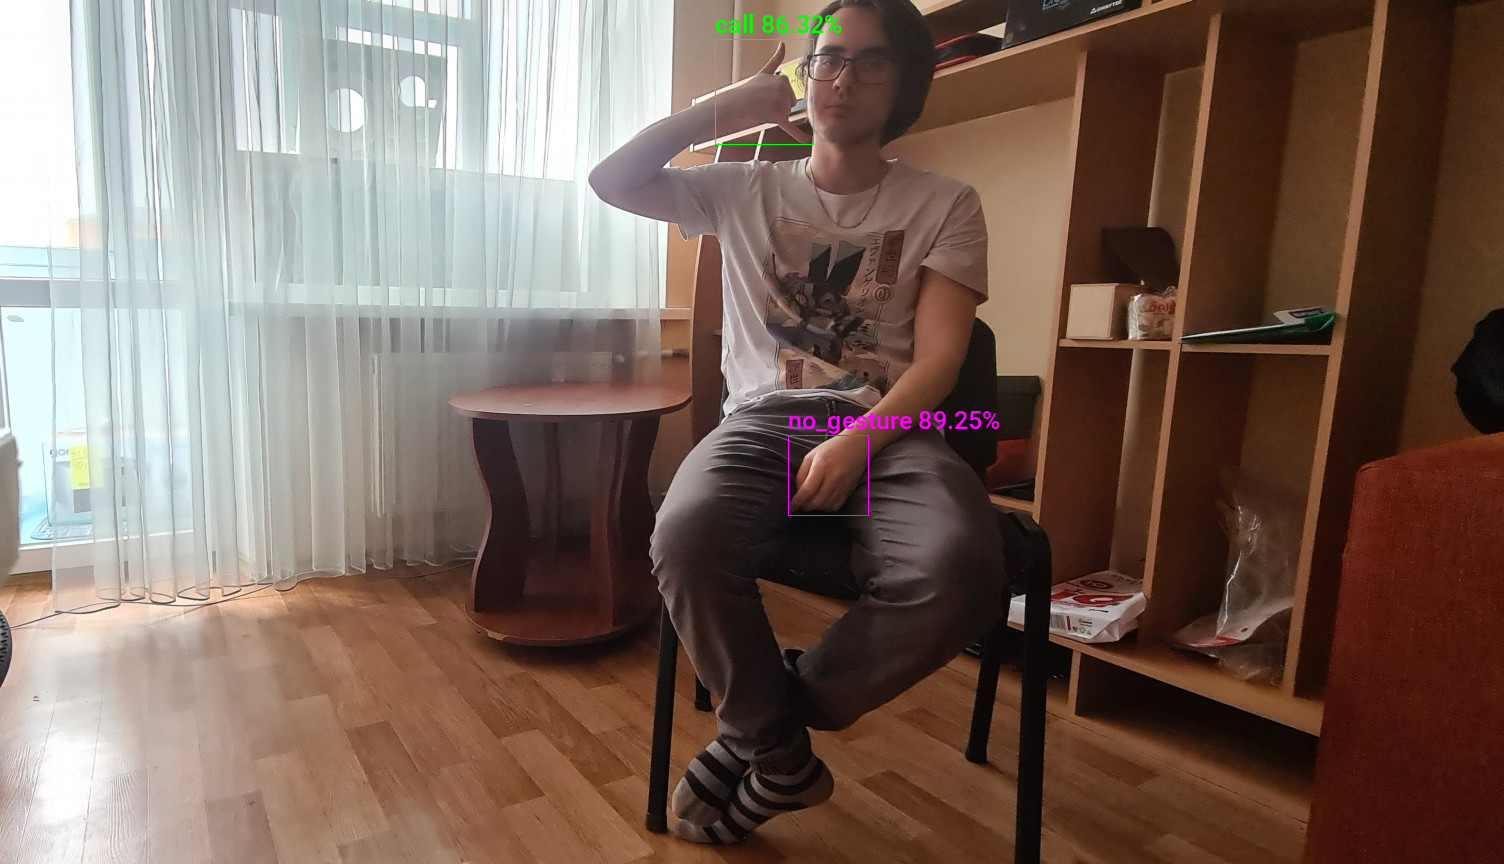

In [33]:
annotated_img = test_img.copy()
draw = ImageDraw.Draw(annotated_img)
fnt_size = 25
for i in proposal_indices:
    x, y, w, h, l, p = proposals[i].values()
    shape = (x, y, x+w, y+h)
    color = tuple([int(ch*255) for ch in colors[proposals[i]['label']]])
    draw.rectangle(shape, outline=color)
    fnt = ImageFont.truetype(font_file, fnt_size)
    draw.multiline_text((x, y-fnt_size-5), f"{labels[l]} {p*100:.2f}%", font=fnt, fill=color)
annotated_img

**Save annotated image**

In [34]:
annotated_img.save('output.png')

**Benchmark OpenVINO IR CPU inference speed**

In [35]:
%%timeit
compiled_model_ir([input_image])

130 ms ± 5.45 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
